<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simple-Linear-GAN-with-batch-normalization" data-toc-modified-id="Simple-Linear-GAN-with-batch-normalization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simple Linear GAN with batch normalization</a></span></li><li><span><a href="#Getting-Started--With-imports" data-toc-modified-id="Getting-Started--With-imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Getting Started  With imports</a></span></li><li><span><a href="#Spectral-Normalization" data-toc-modified-id="Spectral-Normalization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Spectral-Normalization</a></span></li><li><span><a href="#Generator" data-toc-modified-id="Generator-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generator</a></span></li><li><span><a href="#Discriminator" data-toc-modified-id="Discriminator-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Discriminator</a></span></li><li><span><a href="#Noise-Generation" data-toc-modified-id="Noise-Generation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Noise Generation</a></span></li><li><span><a href="#loss-Function" data-toc-modified-id="loss-Function-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>loss Function</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Training</a></span></li></ul></div>

# Simple Linear GAN with batch normalization

[PyTorch documentation](https://pytorch.org/docs/stable/index.html) 

# Getting Started  With imports



In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.utils.parametrize as parametrize


torch.cuda.empty_cache()
torch.manual_seed(0)
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_tensor = image_tensor.detach().cpu()
    image_grid = make_grid(image_tensor[:num_images], nrow=5)
    #plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    return plt.imshow(image_grid.permute(1, 2, 0).squeeze())

# Spectral-Normalization

In [2]:
class sp(nn.Module):
    def forward(self, w,n_power_itter=1,device = "cuda:0"):
        w= w.to(device)
        norm = lambda a:(a/torch.norm(a)).to(device)     # norm: normlization function  
        rows = w.shape[0]                   # rows of the tensor 
        cols = w.view(rows, -1).shape[1]     # columens of the tensor 
        w_vec= w.view(rows,-1).to(device)                # weights tensor to vector
        #print("rows : ",rows)                 # prints for debug
        #print("cols : ",cols)
        u = norm(torch.randn((rows,1))).to(device)       # intalize u , v vectors 
        v = norm(torch.randn((cols,1))).to(device)  
        #print("u: ",u.shape)                  # more prints for debug
        #print("v: ",v.shape)
        #print("w_vec: ",w_vec.shape)
        for _ in range(n_power_itter):               
            v =norm(torch.matmul(w_vec.T,u))
            u =norm(torch.matmul(w_vec,v))
        #print("u: ",u.shape)
        #print("v: ",v.shape)
        #print("w_vec: ",w_vec.shape)
        sigma_w =torch.matmul(u.T ,torch.matmul(w_vec,v)).to(device)  
        sigma_w.to(device) 
        #print(sigma)
        return w/sigma_w

**Data used : MNIST Dataset**
The training images your discriminator will be using is from a dataset called [MNIST](http://yann.lecun.com/exdb/mnist/). It contains 60,000 images of handwritten digits, from 0 to 9.

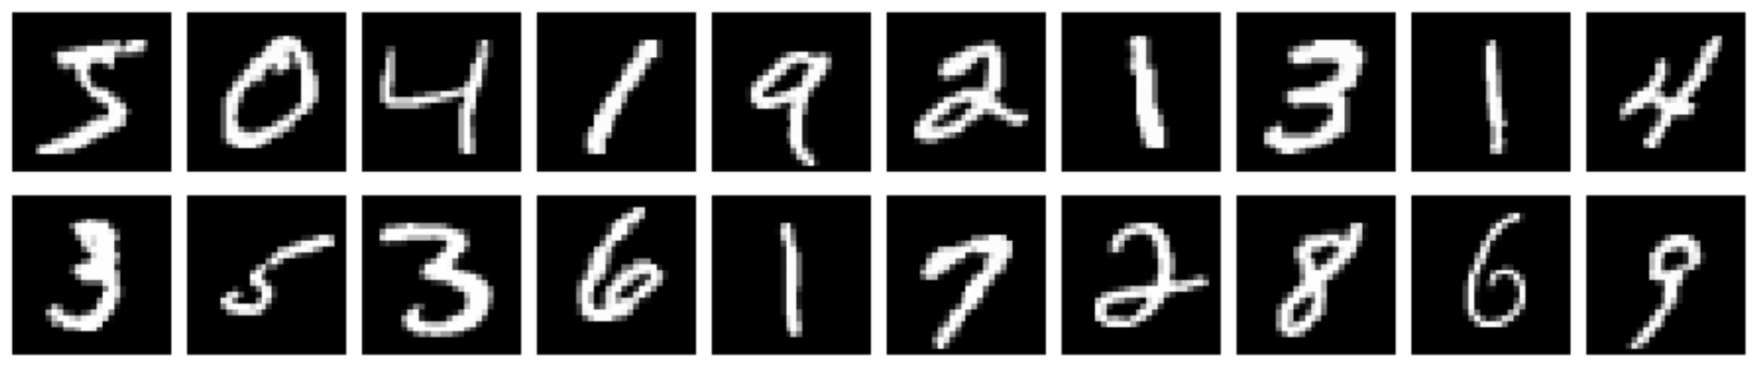

# Generator 

**Generator  Blocks**
the block consist of one DEConv , and Spectral Normalization then one relu activation

**Generator Module**
consist of 3 blocks:

In [3]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.block(z_dim, hidden_dim * 5, kernel_size= 3,stride =2),
            self.block(hidden_dim * 5, hidden_dim * 3, kernel_size= 4,stride =1),
            self.block(hidden_dim * 3, hidden_dim *2, kernel_size= 3,stride =2),
            self.block(hidden_dim * 2, hidden_dim , kernel_size= 3,stride =2),
            nn.ConvTranspose2d(hidden_dim, im_chan, kernel_size= 4,stride =2),
            nn.Tanh()
        )
    def block(self, input_channels, output_channels, kernel_size=3, stride=2):
        return nn.Sequential(
        parametrize.register_parametrization(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),"weight", sp()
        ),
        nn.ReLU(inplace=True)
                        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise.view(len(noise), self.z_dim, 1, 1))
    

# Discriminator


**Discriminator  Blocks**
the block consist of one conv layer and one Leaky-relu activation.

**Discriminator Module**
consist of 2 blocks means 2 Hidden layers each layer followed by Leaky-relu activation the output linear layer.

In [4]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=32):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.block(im_chan, hidden_dim, kernel_size= 4,stride =2 ),
            self.block(hidden_dim, hidden_dim * 2, kernel_size= 4,stride =2 ),
            nn.Conv2d( hidden_dim * 2, 1, kernel_size= 4,stride =2)
        )
        
    def block(self, input_channels, output_channels, kernel_size=4, stride=2):
        return nn.Sequential(
        parametrize.register_parametrization(    
        nn.Conv2d(input_channels, output_channels, kernel_size, stride),"weight", sp()  ),
        nn.Dropout2d(p=0.1, inplace=True),            
        nn.LeakyReLU(0.2, inplace=True)
                        )
    
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

# Noise Generation

In [5]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples,z_dim,device=device)


# loss Function

In [6]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

In [7]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

# Training

  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_epoch: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: using a GPU (CUDA)



In [8]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 100
z_dim = 64
display_epoch =5
batch_size = 512

lr = 0.0003
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load MNIST dataset as tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
dataloader = DataLoader( MNIST('.', download=False, transform=transform),
                            batch_size=batch_size,
                            shuffle=True)
steps_per_ep =len(dataloader)

gen = Generator(z_dim).to(device)
disc = Discriminator().to(device) 

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(.5, 0.999))

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0



In [9]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
#gen = gen.apply(weights_init)
#disc = disc.apply(weights_init)

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 1 ,Step:117 ,Generator loss: 0.5957792254827793 ,discriminator loss: 0.696614802893946


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 2 ,Step:235 ,Generator loss: 0.6958345253083663 ,discriminator loss: 0.6824252605438234


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 3 ,Step:353 ,Generator loss: 0.8805189882799729 ,discriminator loss: 0.6023555819765998


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 4 ,Step:471 ,Generator loss: 1.298996265661919 ,discriminator loss: 0.4334218757132352


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 5 ,Step:589 ,Generator loss: 0.8993257842326569 ,discriminator loss: 0.6925301630744491


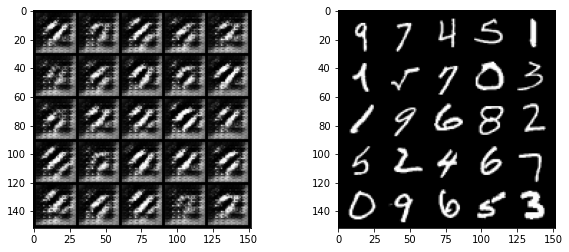

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 6 ,Step:707 ,Generator loss: 0.7967374509168879 ,discriminator loss: 0.6728315318034869


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 7 ,Step:825 ,Generator loss: 0.7531975702208985 ,discriminator loss: 0.683820861123376


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 8 ,Step:943 ,Generator loss: 0.7270993272126731 ,discriminator loss: 0.7075835961406514


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 9 ,Step:1061 ,Generator loss: 0.7406838753465881 ,discriminator loss: 0.7043998261629523


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 10 ,Step:1179 ,Generator loss: 0.7440241792444453 ,discriminator loss: 0.678947402259051


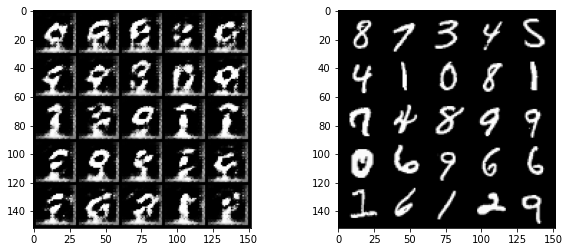

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 11 ,Step:1297 ,Generator loss: 0.7203085175005058 ,discriminator loss: 0.6926615930209725


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 12 ,Step:1415 ,Generator loss: 0.71463561866243 ,discriminator loss: 0.6998206771026223


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 13 ,Step:1533 ,Generator loss: 0.7145208862878508 ,discriminator loss: 0.6920525886244692


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 14 ,Step:1651 ,Generator loss: 0.7087297616368634 ,discriminator loss: 0.6847309495432904


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 15 ,Step:1769 ,Generator loss: 0.715067894529488 ,discriminator loss: 0.6890226269172414


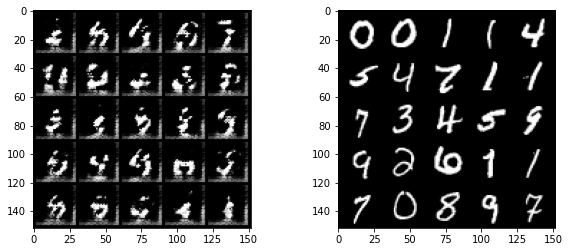

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 16 ,Step:1887 ,Generator loss: 0.6951176478701124 ,discriminator loss: 0.6877421837742045


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 17 ,Step:2005 ,Generator loss: 0.7108901064779797 ,discriminator loss: 0.6889085759550838


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 18 ,Step:2123 ,Generator loss: 0.7131907288300788 ,discriminator loss: 0.6941964924335479


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 19 ,Step:2241 ,Generator loss: 0.7468559544975474 ,discriminator loss: 0.6890949763483921


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 20 ,Step:2359 ,Generator loss: 0.7308221926628534 ,discriminator loss: 0.6911162365291079


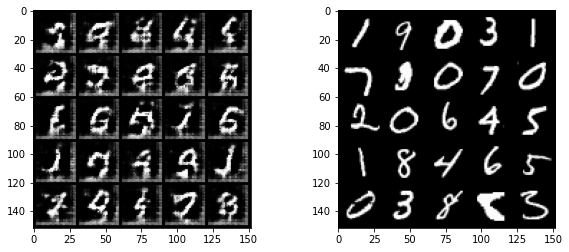

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 21 ,Step:2477 ,Generator loss: 0.7135470711578757 ,discriminator loss: 0.687993759826078


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 22 ,Step:2595 ,Generator loss: 0.7276638801825248 ,discriminator loss: 0.6903564697605067


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 23 ,Step:2713 ,Generator loss: 0.7138251707715498 ,discriminator loss: 0.6905174553394315


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 24 ,Step:2831 ,Generator loss: 0.7094018727035841 ,discriminator loss: 0.6914102586649237


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 25 ,Step:2949 ,Generator loss: 0.7127170747114439 ,discriminator loss: 0.689237442057011


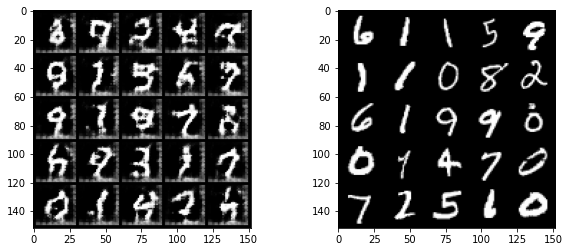

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 26 ,Step:3067 ,Generator loss: 0.7112166151656942 ,discriminator loss: 0.6938807979478676


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 27 ,Step:3185 ,Generator loss: 0.719410660408311 ,discriminator loss: 0.6838840736170949


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 28 ,Step:3303 ,Generator loss: 0.7249106704178504 ,discriminator loss: 0.6879488457057439


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 29 ,Step:3421 ,Generator loss: 0.7213705954915385 ,discriminator loss: 0.691956164473194


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 30 ,Step:3539 ,Generator loss: 0.6918149641004658 ,discriminator loss: 0.6900493740025215


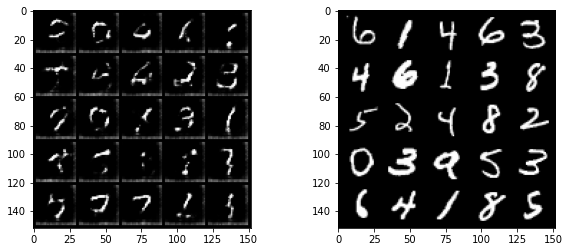

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 31 ,Step:3657 ,Generator loss: 0.7049996511915984 ,discriminator loss: 0.6916876763610517


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 32 ,Step:3775 ,Generator loss: 0.727898493661719 ,discriminator loss: 0.6996846380880328


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 33 ,Step:3893 ,Generator loss: 0.7045787244530045 ,discriminator loss: 0.6974286386522204


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 34 ,Step:4011 ,Generator loss: 0.7182316274966227 ,discriminator loss: 0.6938871039172354


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 35 ,Step:4129 ,Generator loss: 0.7090877936048021 ,discriminator loss: 0.6886950584791477


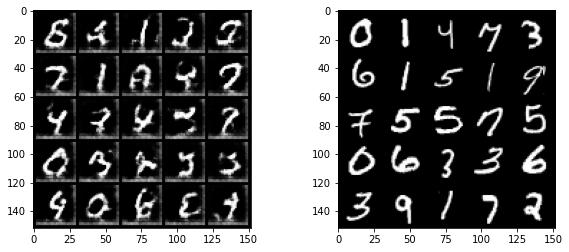

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 36 ,Step:4247 ,Generator loss: 0.7198842107239415 ,discriminator loss: 0.6952385695303899


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 37 ,Step:4365 ,Generator loss: 0.7145150306366257 ,discriminator loss: 0.695348462310888


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 38 ,Step:4483 ,Generator loss: 0.7007694822751865 ,discriminator loss: 0.6894744483091063


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 39 ,Step:4601 ,Generator loss: 0.7003370652259412 ,discriminator loss: 0.694779882491645


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 40 ,Step:4719 ,Generator loss: 0.7243953084541579 ,discriminator loss: 0.6955742270259535


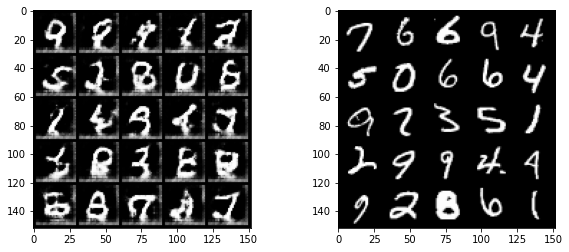

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 41 ,Step:4837 ,Generator loss: 0.7074934446205527 ,discriminator loss: 0.6923548559011035


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 42 ,Step:4955 ,Generator loss: 0.6984919637946759 ,discriminator loss: 0.6904472425832586


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 43 ,Step:5073 ,Generator loss: 0.6909738246162058 ,discriminator loss: 0.6897812798871832


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 44 ,Step:5191 ,Generator loss: 0.7096931171619284 ,discriminator loss: 0.6956522727416732


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 45 ,Step:5309 ,Generator loss: 0.7009238317861394 ,discriminator loss: 0.6959772842415308


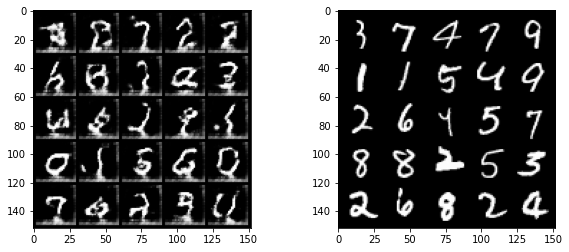

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 46 ,Step:5427 ,Generator loss: 0.6931685381016489 ,discriminator loss: 0.6924220182127875


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 47 ,Step:5545 ,Generator loss: 0.6996879989312867 ,discriminator loss: 0.6918673853752979


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 48 ,Step:5663 ,Generator loss: 0.7058505623017329 ,discriminator loss: 0.693055492841591


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 49 ,Step:5781 ,Generator loss: 0.7093646854667341 ,discriminator loss: 0.6991228835057401


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 50 ,Step:5899 ,Generator loss: 0.7015624718140749 ,discriminator loss: 0.6929306650565843


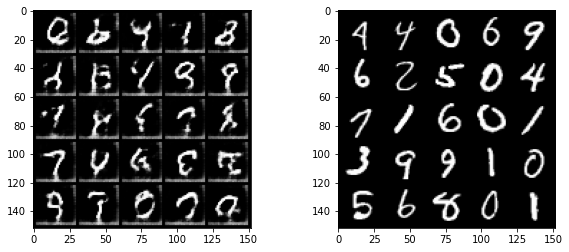

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 51 ,Step:6017 ,Generator loss: 0.6933586920722058 ,discriminator loss: 0.6931310816336488


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 52 ,Step:6135 ,Generator loss: 0.7057541841167514 ,discriminator loss: 0.6968926251944849


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 53 ,Step:6253 ,Generator loss: 0.6974942931684398 ,discriminator loss: 0.690798718040272


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 54 ,Step:6371 ,Generator loss: 0.7005761124319951 ,discriminator loss: 0.6941370463977425


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 55 ,Step:6489 ,Generator loss: 0.69833700283099 ,discriminator loss: 0.6927693561982302


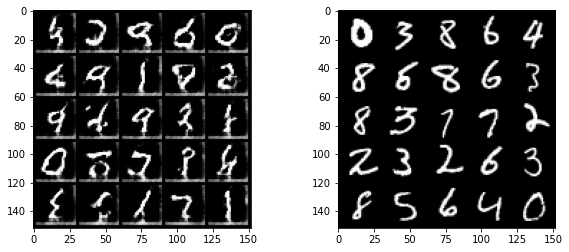

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 56 ,Step:6607 ,Generator loss: 0.7059440001592797 ,discriminator loss: 0.6922909678038902


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 57 ,Step:6725 ,Generator loss: 0.7093752511477068 ,discriminator loss: 0.6913242299677963


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 58 ,Step:6843 ,Generator loss: 0.7124735803927401 ,discriminator loss: 0.6963167655265938


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 59 ,Step:6961 ,Generator loss: 0.7003452626325318 ,discriminator loss: 0.6944271922111511


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 60 ,Step:7079 ,Generator loss: 0.7066059799517616 ,discriminator loss: 0.6946403020519322


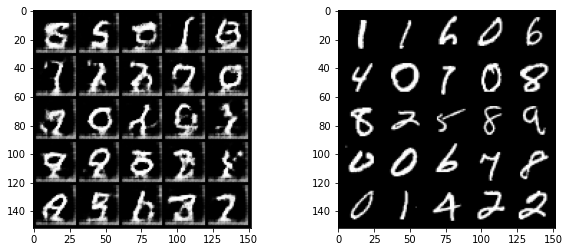

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 61 ,Step:7197 ,Generator loss: 0.7006977786452083 ,discriminator loss: 0.6945328717514616


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 62 ,Step:7315 ,Generator loss: 0.7037073575844195 ,discriminator loss: 0.6933421189502135


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 63 ,Step:7433 ,Generator loss: 0.7115431165291097 ,discriminator loss: 0.6985651239500207


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 64 ,Step:7551 ,Generator loss: 0.6925982383348175 ,discriminator loss: 0.6925981150845347


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 65 ,Step:7669 ,Generator loss: 0.7019452447608365 ,discriminator loss: 0.6951200320559036


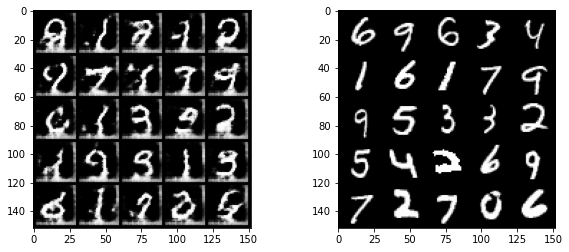

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 66 ,Step:7787 ,Generator loss: 0.6950947834273518 ,discriminator loss: 0.6936179929870673


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 67 ,Step:7905 ,Generator loss: 0.7041684237577144 ,discriminator loss: 0.6950326506364141


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 68 ,Step:8023 ,Generator loss: 0.6969198958348419 ,discriminator loss: 0.694521562527802


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 69 ,Step:8141 ,Generator loss: 0.6986370687767612 ,discriminator loss: 0.6944971215926995


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 70 ,Step:8259 ,Generator loss: 0.683870558516454 ,discriminator loss: 0.6912216155205742


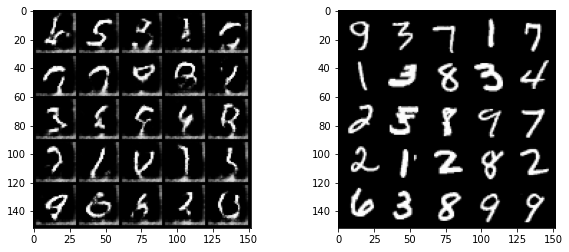

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 71 ,Step:8377 ,Generator loss: 0.6951429106421387 ,discriminator loss: 0.6947350941472134


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 72 ,Step:8495 ,Generator loss: 0.6998715638104132 ,discriminator loss: 0.693287543826184


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 73 ,Step:8613 ,Generator loss: 0.6840702330662028 ,discriminator loss: 0.6917628004389296


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 74 ,Step:8731 ,Generator loss: 0.7065128340559489 ,discriminator loss: 0.6930434900825303


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 75 ,Step:8849 ,Generator loss: 0.6854231822288647 ,discriminator loss: 0.6934119963039784


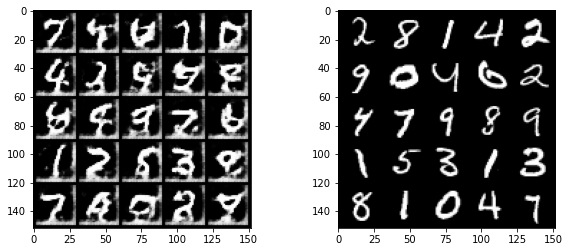

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 76 ,Step:8967 ,Generator loss: 0.6964881536314044 ,discriminator loss: 0.6941510428816589


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 77 ,Step:9085 ,Generator loss: 0.6957165023027841 ,discriminator loss: 0.694616520808915


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 78 ,Step:9203 ,Generator loss: 0.6996971818350131 ,discriminator loss: 0.6926702159946247


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 79 ,Step:9321 ,Generator loss: 0.6954341131751827 ,discriminator loss: 0.6939477561894111


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 80 ,Step:9439 ,Generator loss: 0.7060978877342353 ,discriminator loss: 0.6955891913276607


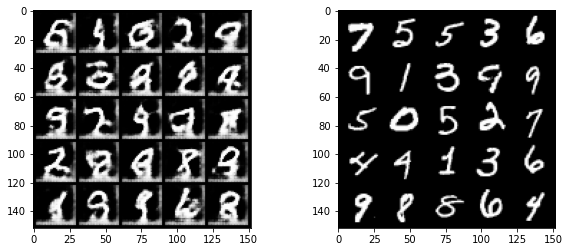

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 81 ,Step:9557 ,Generator loss: 0.7013472146907096 ,discriminator loss: 0.6937339917077852


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 82 ,Step:9675 ,Generator loss: 0.7060610793404658 ,discriminator loss: 0.6957289733118929


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 83 ,Step:9793 ,Generator loss: 0.7079582603301035 ,discriminator loss: 0.6947403489533119


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 84 ,Step:9911 ,Generator loss: 0.7020244941873067 ,discriminator loss: 0.6940639741339926


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 85 ,Step:10029 ,Generator loss: 0.6950940823150894 ,discriminator loss: 0.6911699857752199


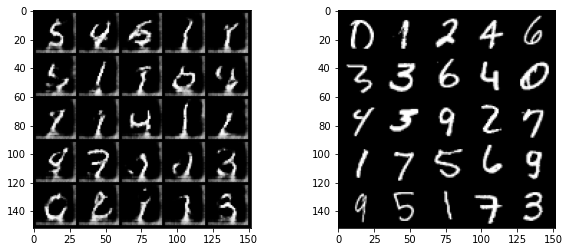

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 86 ,Step:10147 ,Generator loss: 0.6914599164057587 ,discriminator loss: 0.6931406279741713


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 87 ,Step:10265 ,Generator loss: 0.7133921692937106 ,discriminator loss: 0.6959886697389311


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 88 ,Step:10383 ,Generator loss: 0.6924746698242126 ,discriminator loss: 0.6915131943710777


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 89 ,Step:10501 ,Generator loss: 0.7009788458630187 ,discriminator loss: 0.6952891193204007


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 90 ,Step:10619 ,Generator loss: 0.7148084746578997 ,discriminator loss: 0.6949919664253619


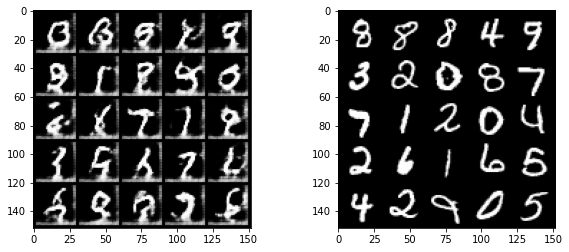

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 91 ,Step:10737 ,Generator loss: 0.7050904247720363 ,discriminator loss: 0.6933079023482434


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 92 ,Step:10855 ,Generator loss: 0.6907091059927207 ,discriminator loss: 0.6926423796152665


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 93 ,Step:10973 ,Generator loss: 0.6918962365489897 ,discriminator loss: 0.6948913467132443


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 94 ,Step:11091 ,Generator loss: 0.7051515281200412 ,discriminator loss: 0.6963870757717197


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 95 ,Step:11209 ,Generator loss: 0.7025643263832997 ,discriminator loss: 0.6932360105595347


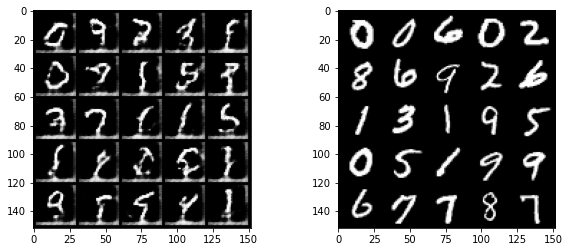

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 96 ,Step:11327 ,Generator loss: 0.7014093828403345 ,discriminator loss: 0.6947539211329763


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 97 ,Step:11445 ,Generator loss: 0.7034668250609252 ,discriminator loss: 0.6952020015756962


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 98 ,Step:11563 ,Generator loss: 0.6802016855296441 ,discriminator loss: 0.6905344401375727


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 99 ,Step:11681 ,Generator loss: 0.6982123735597576 ,discriminator loss: 0.6949517752154403


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 100 ,Step:11799 ,Generator loss: 0.6892616880142082 ,discriminator loss: 0.6902822347010598


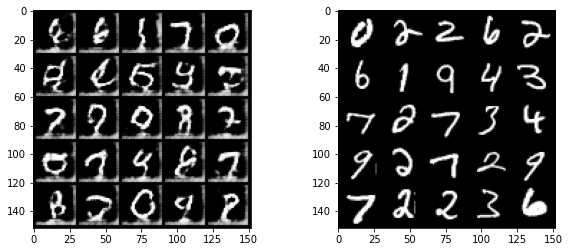

In [10]:
for epoch in range(1,n_epochs+1):
    for real, _ in tqdm(dataloader):
        real = real.to(device)
        cur_batch_size = len(real)

        ### Update discriminator ###
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        
        disc_opt.step()
        ### Update generator ###
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        
        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / steps_per_ep
        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / steps_per_ep
        cur_step += 1
        ### Visualization code ###
       
    print(f"Epoch: {epoch} ,Step:{cur_step-1} ,Generator loss: {mean_generator_loss} ,discriminator loss: {mean_discriminator_loss}")
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    
    if epoch % display_epoch == 0 and display_epoch > 1:
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        plt.figure(1, figsize=(10,4))
        plt.subplot(1,2,1)
        show_tensor_images(fake)
        plt.subplot(1,2,2)
        show_tensor_images(real)
        plt.show()
        
        
